## Enunciado

> Considere la información del proyecto cuya información aparece en la tabla adjunta:
> 1. ¿Cuál es la probabilidad de terminar el proyecto entre 10 y 12 periodos?
> 2. Indique cuales serían las actuaciones a llevar a cabo para reducir con mínimo sobrecoste la duración media del proyecto a 9 periodos.
> 3. Indique cuales serían las actuaciones para poder ejecutar el proyecto con un límite en los recursos de 8 recursos por periodo durante los primeros ocho periodos.
> 4. Calcule el valor del CPI y del SPI para el punto de control de 11 periodos.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
pmule_path = r'/content/gdrive/MyDrive/COMPARTIDOS/COMPARTIDO_AREA/DOCENCIA/Direccion_de_Proyectos/pmule/compartido_publico_alumnos/'

import sys
sys.path.insert(1, pmule_path + "src")
!source {pmule_path}venv/bin/activate
!apt install libgraphviz-dev
!python -m pip install pygraphviz "pandas[excel]==2.2.2"


Mounted at /content/gdrive/
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 k

In [2]:
%load_ext autoreload
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, duracion_tope, desviación, coste_planificado, coste_real, duracion_real, realizado, cur, recursos
     ('A',      'D      ',       2,         1,              0.2,         60,              80,          2,           100,   80,    4 ),
     ('B',      'A      ',       2,         1,              0.3,         70,              60,          2,            80,   10,    2 ),
     ('C',      'B      ',       3,         1,              0.4,         50,               0,          0,             0,   40,    1 ),
     ('D',      '---    ',       4,         3,              0.5,         40,              50,          5,           100,   20,    4 ),
     ('E',      'A      ',       1,         1,              0.1,         30,              30,          3,           100,   30,    3 ),
     ('F',      'D,E    ',       2,         1,              0.3,         10,              10,          3,            80,   40,    5 ),
     ('G',      '---    ',       4,         1,              0.1,         40,              50,          3,           100,   20,    4 ),
     ('H',      'G      ',       4,         2,              0.5,        110,             140,          4,            90,   50,    2 ),
     ('I',      'D      ',       2,         1,              0.1,         90,              70,          1,            50,   60,    3 ),
     ('J',      'F,H,I,K',       2,         1,              0.4,         50,               0,          0,             0,   70,    1 ),
     ('K',      'D,G    ',       4,         1,              0.2,         40,              30,          2,            60,   90,    2 ),
     ('L',      'H,K    ',       1,         1,              0.2,         30,               0,          0,             0,   10,    3 ),
] ,columns=['activity', 'predecessor', 'duration', 'cap_duration', 'standard_deviation', 'planned_value', 'actual_cost',
            'actual_duration', 'performed', 'ucr', 'resources']).set_index('activity')
datos_enunciado

,predecessor,duration,cap_duration,standard_deviation,planned_value,actual_cost,actual_duration,performed,ucr,resources
activity,,,,,,,,,,
A,D,2,1,0.2,60,80,2,100,80,4
B,A,2,1,0.3,70,60,2,80,10,2
C,B,3,1,0.4,50,0,0,0,40,1
D,---,4,3,0.5,40,50,5,100,20,4
E,A,1,1,0.1,30,30,3,100,30,3
F,"D,E",2,1,0.3,10,10,3,80,40,5
G,---,4,1,0.1,40,50,3,100,20,4
H,G,4,2,0.5,110,140,4,90,50,2
I,D,2,1,0.1,90,70,1,50,60,3


## Solución
### Apartado 1

> ¿Cuál es la probabilidad de terminar el proyecto entre 10 y 12 semanas?


#### Duración media del proyecto

En pmule (project management at ULE) está el código que utilizamos para calcular los valores del PERT.

In [3]:
%autoreload 2

from pmule import ProjectGraph, PredecessorTable

In [4]:
datos_proyecto=datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,L
activities,,,,,,,,,,,,
A,,,,True,,,,,,,,
B,True,,,,,,,,,,,
C,,True,,,,,,,,,,
D,,,,,,,,,,,,
E,True,,,,,,,,,,,
F,,,,,True,,,,,,,
G,,,,,,,,,,,,
H,,,,,,,True,,,,,
I,,,,True,,,,,,,,


La clase PertGraph permite visualizar el grafo PERT, el diagrama de Gantt así como realizar el cálculo de tiempos tempranos, tardíos y de las holguras totales.

##### Grafo PERT con numeración de nodos

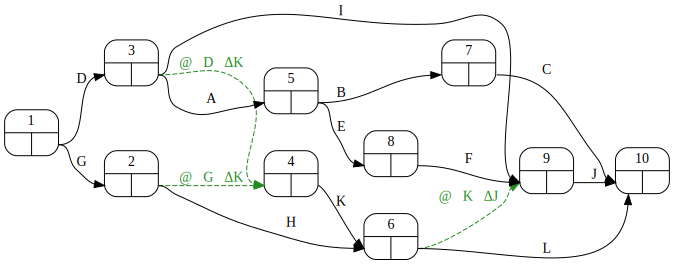

In [5]:
proyecto = prelaciones.create_project()
proyecto.pert()

##### Matriz de Zaderenko

In [6]:
proyecto.zaderenko(durations=datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,10,early
1,,4.0,4.0,,,,,,,,0.0
2,,,,0.0,,4.0,,,,,4.0
3,,,,0.0,2.0,,,,2.0,,4.0
4,,,,,,4.0,,,,,4.0
5,,,,,,,2.0,1.0,,,6.0
6,,,,,,,,,0.0,1.0,8.0
7,,,,,,,,,,3.0,8.0
8,,,,,,,,,2.0,,7.0
9,,,,,,,,,,2.0,9.0
10,,,,,,,,,,,11.0


In [7]:
resultados_pert = proyecto.calculate_pert(durations=datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,4,5
3,4,4
4,4,5
5,6,6
6,8,9
7,8,8
8,7,7
9,9,9
10,11,11


##### Duración media del proyecto

La duración media del proyecto es:

In [8]:
duracion_media_proyecto = proyecto.duration(durations=datos_proyecto['duration'])
duracion_media_proyecto

11

#### Varianza de la duración del proyecto
Para determinar la varianza de la duración del proyecto es necesario determinar la varianza de cada rama del camino crítico.

##### Holguras

In [9]:
resultados_pert['activities'][['H_total']]

,H_total
@∇D⤑ΔK,1
@∇G⤑ΔK,1
@∇K⤑ΔJ,1
A,0
B,0
C,0
D,0
E,0
F,0
G,1


##### Camino crítico

In [10]:
camino_critico = proyecto.critical_path(durations=datos_proyecto['duration'])
camino_critico

{'Route_8': ['D', 'A', 'B', 'C'], 'Route_9': ['D', 'A', 'E', 'F', 'J']}

##### Grafo PERT con indicación del camino crítico

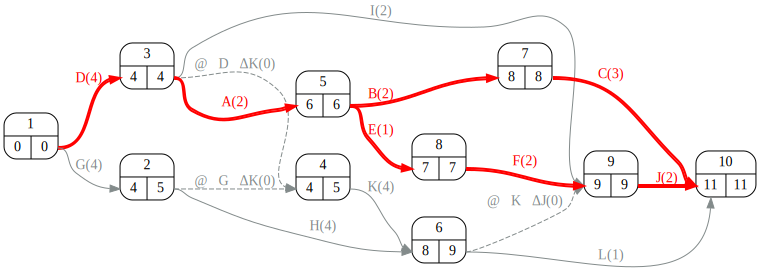

In [11]:
proyecto.pert(durations=datos_proyecto['duration'])

##### Varianza de cada rama

A la vista del grafo PERT el camino crítico se compone de 2 ramas.

In [12]:
datos_proyecto['variance'] = datos_proyecto.eval('standard_deviation ** 2')
desviacion_proyecto = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                   variances=datos_proyecto['variance']
                                                  )
desviacion_proyecto

Variance path: Route_8 : 0.54
Variance path: Route_9 : 0.55
Project duration variance: 0.55
Project duration standard deviation: 0.7416198487095663


0.7416198487095663

#### Probabilidad de terminar entre 10 y 12 periodos

In [13]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_12 = norm.cdf(12, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_10 = norm.cdf(10, loc=duracion_media_proyecto, scale=desviacion_proyecto)

probabilidad_de_terminar_entre_10_y_12 = probabilidad_de_terminar_antes_de_12 - probabilidad_de_terminar_antes_de_10
probabilidad_de_terminar_entre_10_y_12 * 100

82.24701475878464

### Apartado 2
> Indique cuales serían las actuaciones a llevar a cabo para reducir con mínimo sobrecoste la duración media del proyecto a 9 periodos.

#### Reducción a 9 periodos

In [14]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                min_durations=datos_proyecto['cap_duration'],
                costs=datos_proyecto['ucr'],
                reduction=2)
ackoff

D shape (12,)
Path matrix shape (9, 12)


Step: 0,	 Best option: ['D'], 	 Cost: 20, 	 Critical paths: ['Route_8', 'Route_9']
Step: 1,	 Best option: ['G', 'B', 'F'], 	 Cost: 70, 	 Critical paths: ['Route_2', 'Route_4', 'Route_8', 'Route_9']





,A,B,C,D,E,F,G,H,I,J,K,L,0,1,2
Route_1,,,,,,,20.0,50.0,,,,10.0,9.0,9.0,8.0
Route_2,,,,,,,20.0,50.0,,70.0,,,10.0,10.0,9.0
Route_3,,,,,,,20.0,,,,90.0,10.0,9.0,9.0,8.0
Route_4,,,,,,,20.0,,,70.0,90.0,,10.0,10.0,9.0
Route_5,,,,20.0,,,,,60.0,70.0,,,8.0,7.0,7.0
Route_6,,,,20.0,,,,,,,90.0,10.0,9.0,8.0,8.0
Route_7,,,,20.0,,,,,,70.0,90.0,,10.0,9.0,9.0
Route_8,80.0,10.0,40.0,20.0,,,,,,,,,11.0,10.0,9.0
Route_9,80.0,,,20.0,30.0,40.0,,,,70.0,,,11.0,10.0,9.0
0,1.0,1.0,2.0,1.0,0.0,1.0,3.0,2.0,1.0,1.0,3.0,0.0,,,


### Apartado 3
> Indique cuales serían las actuaciones para poder ejecutar el proyecto con un límite en los recursos de 8 recursos por periodo durante los primeros ocho periodos.

Para responder este apartado es necesario representar la demanda de recursos a lo largo del tiempo.

In [17]:
proyecto_asignacion = proyecto.copy()
proyecto_asignacion.gantt(datos_proyecto,
                          'duration',
                          'resources',
                          total='fila',
                          holguras=True)

,1,2,3,4,5,6,7,8,9,10,11,H_total
A,,,,,4,4,,,,,,0.000000
B,,,,,,,2,2,,,,0.000000
C,,,,,,,,,1,1,1,0.000000
D,4,4,4,4,,,,,,,,0.000000
E,,,,,,,3,,,,,0.000000
F,,,,,,,,5,5,,,0.000000
G,4,4,4,4,,,,,,,,1.000000
H,,,,,2,2,2,2,,,,1.000000
I,,,,,3,3,,,,,,3.000000
J,,,,,,,,,,1,1,0.000000


La demanda de recursos actual infringe el límite impuesto. Es necesario aplicar el algoritmo de asignación.

#### Algoritmo de asignación

 El primer periodo problemático es el 5.

##### Asignación periodo 5

De las actividades inicialmente programadas para el periodo 5 la actividad A es crítica y se programa consumiendo 4 recursos. Atendiendo a la holgura para la prioridad se elige programar las actividades H y K, desplazando I.

In [18]:
duration_resources = datos_proyecto[['duration','resources']].copy()
duration_resources = proyecto_asignacion.desplazar(data=duration_resources, duration_label='duration', resource_label='resources', I = 1)

Suma de cuadrados: 795.0 



,1,2,3,4,5,6,7,8,9,10,11,H_total
A,,,,,4.000000,4.000000,,,,,,0.000000
B,,,,,,,2.000000,2.000000,,,,0.000000
C,,,,,,,,,1.000000,1.000000,1.000000,0.000000
D,4.000000,4.000000,4.000000,4.000000,,,,,,,,0.000000
E,,,,,,,3.000000,,,,,0.000000
F,,,,,,,,5.000000,5.000000,,,0.000000
G,4.000000,4.000000,4.000000,4.000000,,,,,,,,1.000000
H,,,,,2.000000,2.000000,2.000000,2.000000,,,,1.000000
I,,,,,,3.000000,3.000000,,,,,2.000000
J,,,,,,,,,,1.000000,1.000000,0.000000


##### Asignación periodo 6

Las actividades A, H y K ya se están ejecutando y no se interrumpen. Se desplaza I.

In [19]:
duration_resources = proyecto_asignacion.desplazar(data=duration_resources, duration_label='duration', resource_label='resources', I = 1)

Suma de cuadrados: 813.0 



,1,2,3,4,5,6,7,8,9,10,11,H_total
A,,,,,4.000000,4.000000,,,,,,0.000000
B,,,,,,,2.000000,2.000000,,,,0.000000
C,,,,,,,,,1.000000,1.000000,1.000000,0.000000
D,4.000000,4.000000,4.000000,4.000000,,,,,,,,0.000000
E,,,,,,,3.000000,,,,,0.000000
F,,,,,,,,5.000000,5.000000,,,0.000000
G,4.000000,4.000000,4.000000,4.000000,,,,,,,,1.000000
H,,,,,2.000000,2.000000,2.000000,2.000000,,,,1.000000
I,,,,,,,3.000000,3.000000,,,,1.000000
J,,,,,,,,,,1.000000,1.000000,0.000000


##### Asignación periodo 7

Las actividades H y K ya están en ejecución y no se interrumpen. B y E son críticas pero E es más corta. Se programa H, K y E desplazando B e I.

In [20]:
duration_resources = proyecto_asignacion.desplazar(data=duration_resources, duration_label='duration', resource_label='resources', I = 1, B = 1)

Suma de cuadrados: 807.0 



,1,2,3,4,5,6,7,8,9,10,11,12,H_total
A,,,,,4.000000,4.000000,,,,,,,0.000000
B,,,,,,,,2.000000,2.000000,,,,0.000000
C,,,,,,,,,,1.000000,1.000000,1.000000,0.000000
D,4.000000,4.000000,4.000000,4.000000,,,,,,,,,0.000000
E,,,,,,,3.000000,,,,,,1.000000
F,,,,,,,,5.000000,5.000000,,,,1.000000
G,4.000000,4.000000,4.000000,4.000000,,,,,,,,,2.000000
H,,,,,2.000000,2.000000,2.000000,2.000000,,,,,2.000000
I,,,,,,,,3.000000,3.000000,,,,1.000000
J,,,,,,,,,,1.000000,1.000000,,1.000000


##### Asignación periodo 8

En este periodo se está ejecutando H y K que no se interrumpen. Se ejecuta B por ser crítica y se desplazan F e I.

In [21]:
duration_resources = proyecto_asignacion.desplazar(data=duration_resources, duration_label='duration', resource_label='resources', F = 1, I = 1)

Suma de cuadrados: 727.0 



,1,2,3,4,5,6,7,8,9,10,11,12,H_total
A,,,,,4.000000,4.000000,,,,,,,0.000000
B,,,,,,,,2.000000,2.000000,,,,0.000000
C,,,,,,,,,,1.000000,1.000000,1.000000,0.000000
D,4.000000,4.000000,4.000000,4.000000,,,,,,,,,0.000000
E,,,,,,,3.000000,,,,,,0.000000
F,,,,,,,,,5.000000,5.000000,,,0.000000
G,4.000000,4.000000,4.000000,4.000000,,,,,,,,,2.000000
H,,,,,2.000000,2.000000,2.000000,2.000000,,,,,2.000000
I,,,,,,,,,3.000000,3.000000,,,0.000000
J,,,,,,,,,,,1.000000,1.000000,0.000000


### Apartado 4
> Calcule el valor del CPI y del SPI para el punto de control de 11 periodos.


In [22]:
PV = datos_proyecto['planned_value'].sum()
PV

620

In [23]:
EV = datos_proyecto.eval('planned_value * performed / 100').sum()
EV

402.0

In [24]:
AC = datos_proyecto['actual_cost'].sum()
AC

520

In [25]:
CPI = EV/AC
CPI

0.7730769230769231

In [26]:
SPI=EV/PV
SPI

0.6483870967741936